<a href="https://colab.research.google.com/github/jeffbgreene/geology-558/blob/main/Scikit_image_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Scikit-Image Exploration**

#### Author: Jeff Greene
#### Date : 2/23/2025

In [16]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np # Import numpy
from skimage.color import rgb2gray
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from skimage.filters import unsharp_mask
from skimage.color import rgb2hsv
from skimage import color

from skimage.feature import daisy
import matplotlib.pyplot as plt
from skimage.filters import meijering, sato, frangi, hessian

In [17]:
file_url = 'https://raw.githubusercontent.com/jeffbgreene/geology-558/main/Mineral_Moon.webp'

try:
    # Fetch the image data from the URL
    response = requests.get(file_url, stream=True)
    response.raise_for_status()  # Raise an exception for bad responses (4xx or 5xx)

    # Open the image using BytesIO to handle the data as an in-memory file
    img = Image.open(BytesIO(response.content))
    print("File was opened correctly and saved to variable")

except FileNotFoundError:
    print("Error: The file was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

File was opened correctly and saved to variable


## **Image Selected for this assignment**

---
This image is a mosaic of 53 images from the Galileo spacecraft collected through 3 spectral filters. As NASA/JPL states the picture contains "exaggerated false-color scheme to explore the composition of the lunar surface as changes in mineral content produce subtle color differences in reflected light." I like this picture because the spectral patterns, though exagerated in this photo, can and are being used to identify mineral concentrations as another piece of evidence to inform proposed prospecting campaigns.

Image from: https://www.nasa.gov/image-article/mineral-moon/


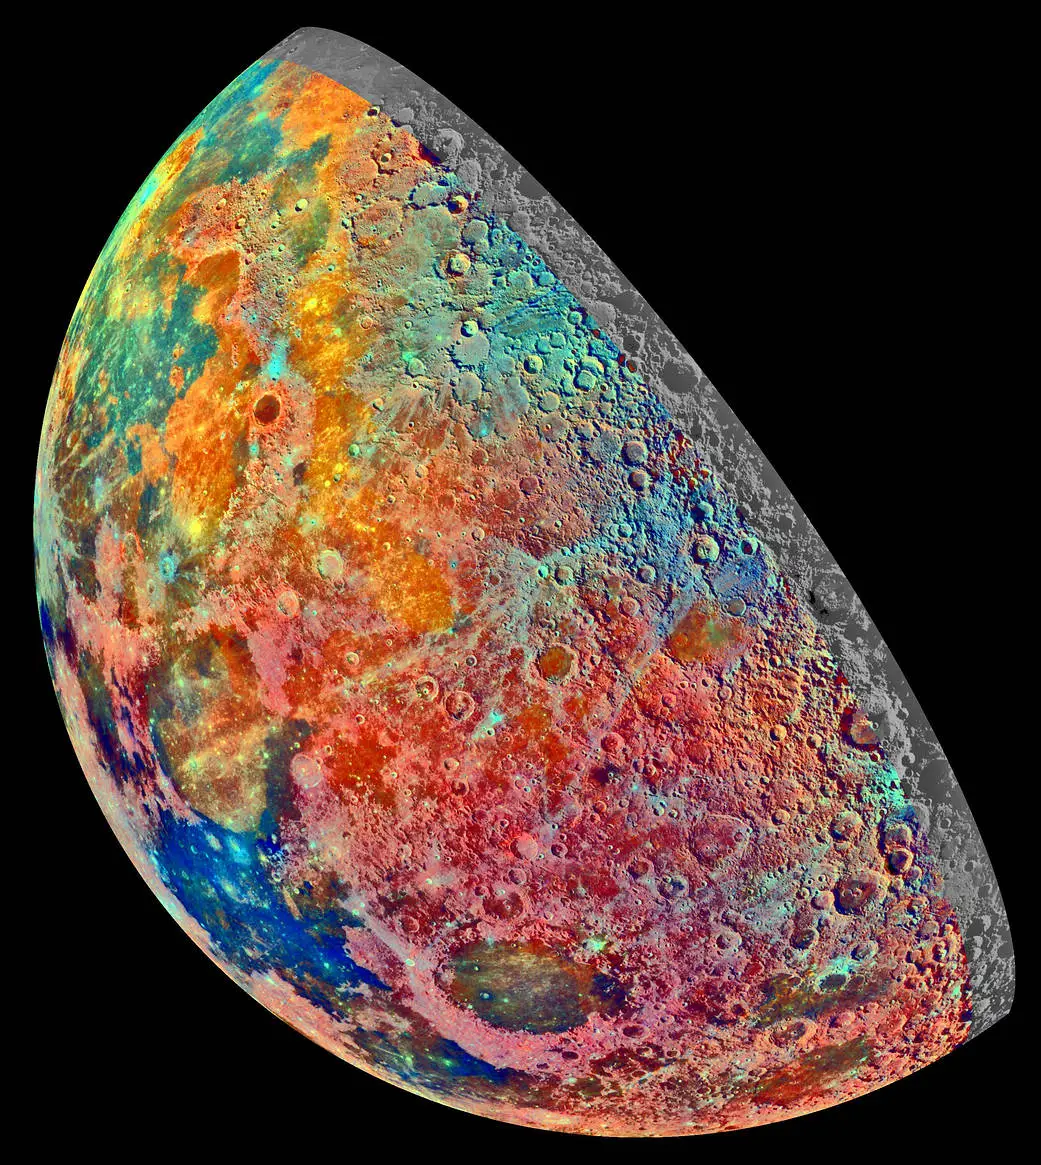

In [18]:
img

## **RGB to HSV**

---

Transforming raw spectral data to hue, saturation, and value could make it easier to inspect color components seperately. I learned that this method could possibly be used for transforming images to help with object detection and color segmentation.

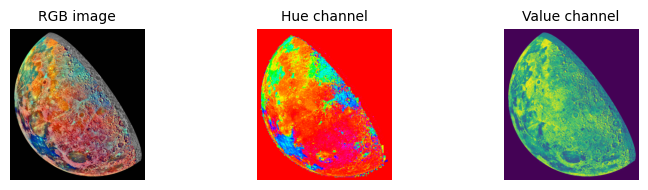

In [19]:
img_np = np.array(img)
hsv_img = rgb2hsv(img_np)
hue_img = hsv_img[:, :, 0]
value_img = hsv_img[:, :, 2]

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(8, 2))

ax0.imshow(img)
ax0.set_title("RGB image")
ax0.axis('off')
ax1.imshow(hue_img, cmap='hsv')
ax1.set_title("Hue channel")
ax1.axis('off')
ax2.imshow(value_img)
ax2.set_title("Value channel")
ax2.axis('off')

fig.tight_layout()

## Ridge operators

---

These filters are used to detect ridge like structures. In a picture such as the one I'm using, the crater ridges seem to become more pronounced in some of the filters, as well as the edge of the Moon. One thing that I thought of whille utilizing this filter is that it could be used to find surface lava flow channels and lava tubes.  

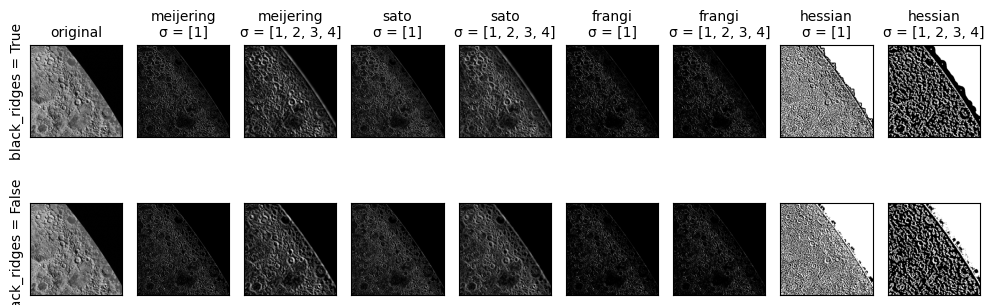

In [20]:



def original(image, **kwargs):
    """Return the original image, ignoring any kwargs."""
    return image


image = color.rgb2gray(img)[300:700, 500:900]
cmap = plt.cm.gray

plt.rcParams["axes.titlesize"] = "medium"
axes = plt.figure(figsize=(10, 4)).subplots(2, 9)
for i, black_ridges in enumerate([True, False]):
    for j, (func, sigmas) in enumerate(
        [
            (original, None),
            (meijering, [1]),
            (meijering, range(1, 5)),
            (sato, [1]),
            (sato, range(1, 5)),
            (frangi, [1]),
            (frangi, range(1, 5)),
            (hessian, [1]),
            (hessian, range(1, 5)),
        ]
    ):
        result = func(image, black_ridges=black_ridges, sigmas=sigmas)
        axes[i, j].imshow(result, cmap=cmap)
        if i == 0:
            title = func.__name__
            if sigmas:
                title += f"\n\N{GREEK SMALL LETTER SIGMA} = {list(sigmas)}"
            axes[i, j].set_title(title)
        if j == 0:
            axes[i, j].set_ylabel(f'{black_ridges = }')
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

plt.tight_layout()
plt.show()

## Image Registration

---
This technique is use for cross-correlation to find similarities/differences between different pictures. I learned that this technique could be used for correlating pictures taken at different times or with seperate sensors.



Known offset (y, x): (-22.4, 13.32)


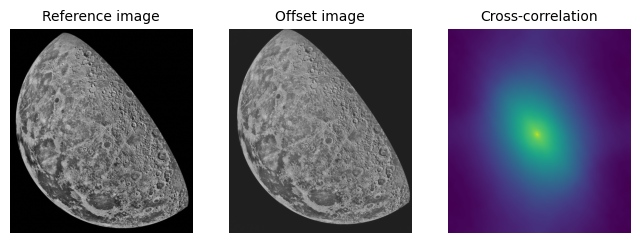

Detected pixel offset (y, x): [ 22. -13.]


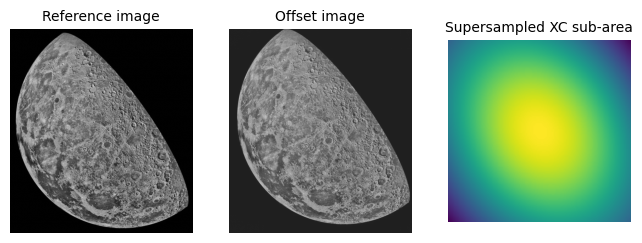

Detected subpixel offset (y, x): [ 22.4  -13.32]


In [21]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage.registration import phase_cross_correlation
from skimage.registration._phase_cross_correlation import _upsampled_dft
from scipy.ndimage import fourier_shift

# Convert the PIL Image to a NumPy array
image_np = np.array(img)

# Convert the image to grayscale if it's not already
if image_np.ndim == 3:
    image_np = np.mean(image_np, axis=2)  # Average color channels to get grayscale

shift = (-22.4, 13.32)
# The shift corresponds to the pixel offset relative to the reference image

# Apply fourier_shift to the grayscale image
offset_image = fourier_shift(np.fft.fftn(image_np), shift)
offset_image = np.fft.ifftn(offset_image)
print(f'Known offset (y, x): {shift}')
# pixel precision first
# The problem was here, image was a WebPImageFile and needed to be converted to a numpy array
shift, error, diffphase = phase_cross_correlation(image_np, offset_image) # Changed 'image' to 'image_np'

fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1)
ax3 = plt.subplot(1, 3, 3)

ax1.imshow(image_np, cmap='gray') # Changed 'image' to 'image_np'
ax1.set_axis_off()
ax1.set_title('Reference image')

ax2.imshow(offset_image.real, cmap='gray')
ax2.set_axis_off()
ax2.set_title('Offset image')

# Show the output of a cross-correlation to show what the algorithm is
# doing behind the scenes
image_product = np.fft.fft2(image_np) * np.fft.fft2(offset_image).conj() # Changed 'image' to 'image_np'
cc_image = np.fft.fftshift(np.fft.ifft2(image_product))
ax3.imshow(cc_image.real)
ax3.set_axis_off()
ax3.set_title("Cross-correlation")

plt.show()

print(f'Detected pixel offset (y, x): {shift}')

# subpixel precision
shift, error, diffphase = phase_cross_correlation(
    image_np, offset_image, upsample_factor=100 # Changed 'image' to 'image_np'
)

fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1)
ax3 = plt.subplot(1, 3, 3)

ax1.imshow(image_np, cmap='gray') # Changed 'image' to 'image_np'
ax1.set_axis_off()
ax1.set_title('Reference image')

ax2.imshow(offset_image.real, cmap='gray')
ax2.set_axis_off()
ax2.set_title('Offset image')

# Calculate the upsampled DFT, again to show what the algorithm is doing
# behind the scenes.  Constants correspond to calculated values in routine.
# See source code for details.
cc_image = _upsampled_dft(image_product, 150, 100, (shift * 100) + 75).conj()
ax3.imshow(cc_image.real)
ax3.set_axis_off()
ax3.set_title("Supersampled XC sub-area")


plt.show()

print(f'Detected subpixel offset (y, x): {shift}')

## Unsharp masking

---

This technique can be used to enhance high-frequency details by removing blurring in the picture. I learned that this technique could also be appiled to sharpen features in the image.

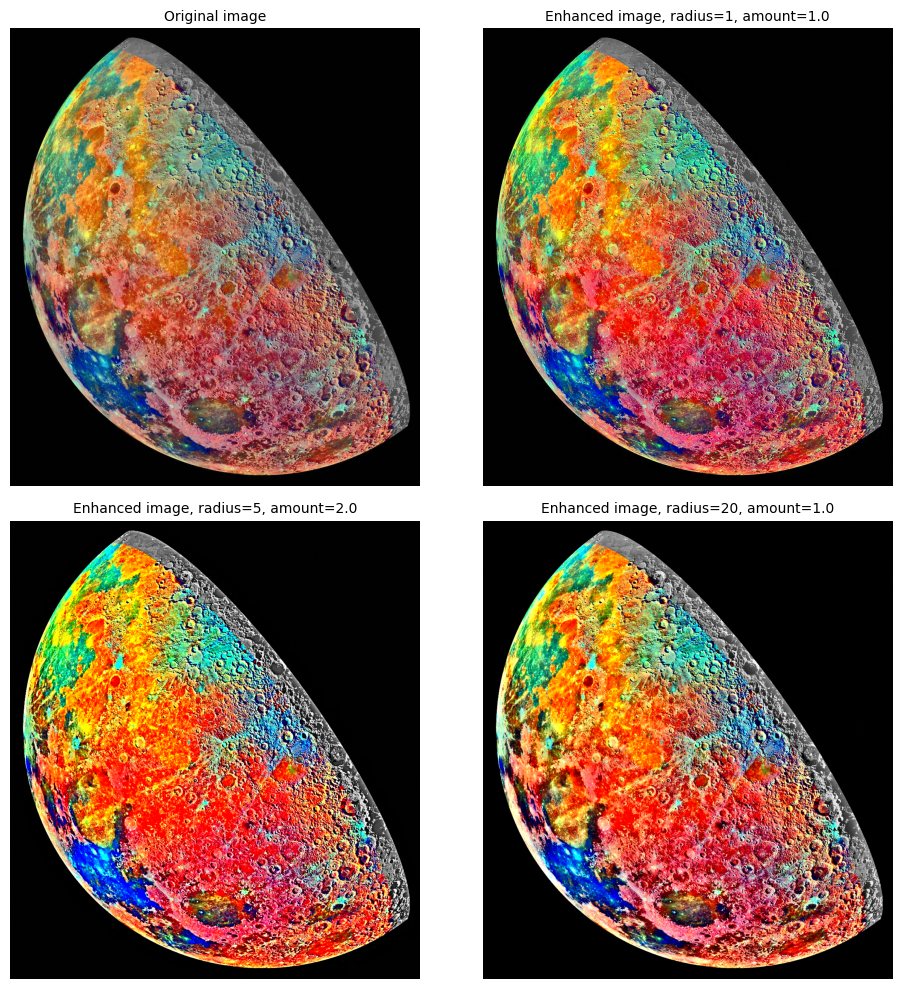

In [22]:

image = img_np
result_1 = unsharp_mask(image, radius=1, amount=1)
result_2 = unsharp_mask(image, radius=5, amount=2)
result_3 = unsharp_mask(image, radius=20, amount=1)

fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10, 10))
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original image')
ax[1].imshow(result_1, cmap=plt.cm.gray)
ax[1].set_title('Enhanced image, radius=1, amount=1.0')
ax[2].imshow(result_2, cmap=plt.cm.gray)
ax[2].set_title('Enhanced image, radius=5, amount=2.0')
ax[3].imshow(result_3, cmap=plt.cm.gray)
ax[3].set_title('Enhanced image, radius=20, amount=1.0')

for a in ax:
    a.axis('off')
fig.tight_layout()
plt.show()

## Dense DAISY feature description

---

This algorithm is used to generate dense image descriptors, basically the features at every pixel of an image. I learned that this algorithm is simlar to the SIFT Discriptor which I used in my Computer Vision and robotics courses here at Mines.

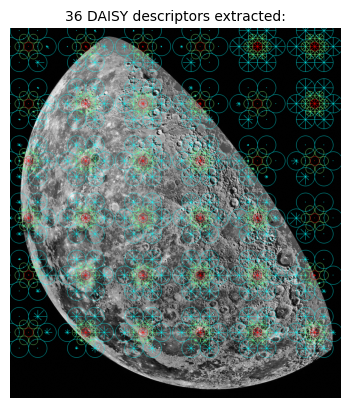

In [23]:
img = img_np
# Convert the color image to grayscale
gray_img = rgb2gray(img)

descs, descs_img = daisy(
    gray_img, step=180, radius=58, rings=2, histograms=6, orientations=8, visualize=True # Pass the grayscale image
)

fig, ax = plt.subplots()
ax.axis("off")
ax.imshow(descs_img)
descs_num = descs.shape[0] * descs.shape[1]
ax.set_title(f"{descs_num} DAISY descriptors extracted:")
plt.show()

## Scikit-Image Reflection

---

I liked reading about the DAISY in comparison to SIFT, as DAISY is computationally faster but less robust when dealing with image deformations. I find algorithms like this interesting, as SIFT is used on the Mars Perseverance rover. In the future I would like to do comparisons of the performance of SIFT vs DAISY for feature description. As far as the algorithms, techniques and filters I used in this notebook, I think they could all be helpful as humans begin to try to determine the best location to extract resources from celestial bodies. As discussed in my notebook, I could see  the use of RGB to HSV useful in translating the complex spectral information into a more intuitive color representation for analysis or visualization purposes. I touched on the usefulness of Ridge operators to help find lava channels and collapsed lava tubes that might be hard to identify. This would be useful to astronauts on the Moon so that they are aware of potential hazards. Image registration could be used to align multiple images of the same scene taken from different viewpoints, times, or sensors for comparison. I didn’t find the cross correlation that was done in my example very helpful, so I would need to spend more time looking into that. Finally, I could see the Unsharp masking helpful in removing the blur from images to help sharpen certain features so that they could be more easily identified. In conclusion, the algorithms and packages in this library prove extremely valuable for image preprocessing and I look forward to exploring them more in the future.